# Healthcare Final Project (Fall 2023): Prediction and Data Visualization of Sepsis
### Yihan Li (yl10798) Yantao Luo (yl5929)

In [25]:
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter

## 1. Data Analysis and Preprocessing

In [26]:
sepsis_df = pd.read_csv('Dataset.csv')
sepsis_df = sepsis_df.drop(columns='Unnamed: 0')
sepsis_df = sepsis_df[sepsis_df['Patient_ID'] < 100000]
# df_train = combined.drop(rows_to_drop.index)
sepsis_df.to_csv('sepsis_df.csv', index=False)
sepsis_df.head()

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072


In [27]:
# Drop Administrative Data
columns_to_drop = {'SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium', 
'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2'}
sepsis_df = sepsis_df.drop(columns=columns_to_drop)

### 1.1 Data Inspection

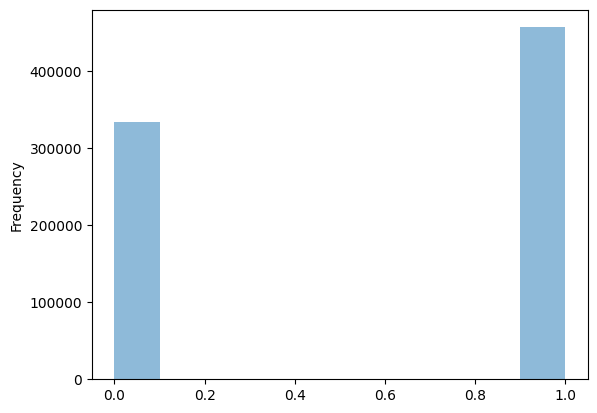

In [28]:
sepsis_df.Gender.plot.hist(alpha=0.5);

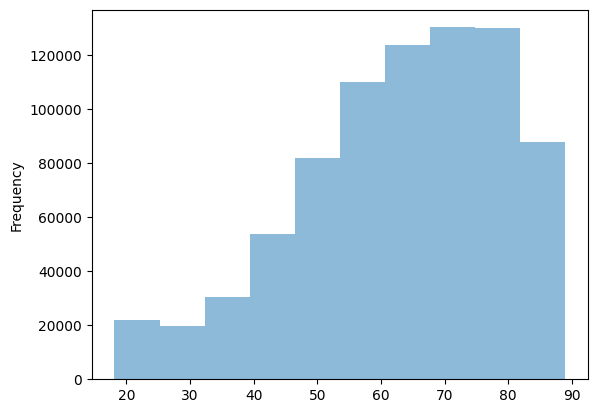

In [29]:
sepsis_df.Age.plot.hist(alpha=0.5);

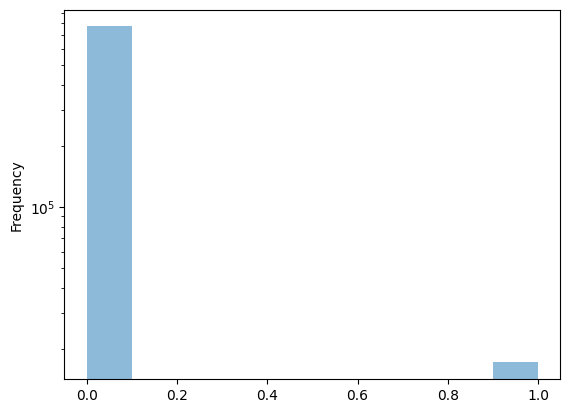

In [30]:
sepsis_df.SepsisLabel.plot.hist(alpha=0.5, logy=True);

### 1.2 Data Imputation

In [31]:
# convert gender to one-hot labels
genders = pd.get_dummies(sepsis_df.Gender, prefix='Gender', columns=['Male', 'Female'])
sepsis_df = sepsis_df.join(genders)
sepsis_df = sepsis_df.drop(columns="Gender")

In [32]:
# remove outliers using zscore
# sepsis_df = sepsis_df[(np.abs(stats.zscore(sepsis_df)) < 3).all(axis=1)]
# labels = sepsis_df[["Patient_ID", "SepsisLabel"]]
# sepsis_df = sepsis_df.drop(columns=["Patient_ID", "SepsisLabel"])
# sepsis_df = sepsis_df[np.abs(sepsis_df-sepsis_df.mean()) <= (3*sepsis_df.std())]
# sepsis_df = pd.concat([sepsis_df, labels], axis=1)
# sepsis_df.head()

In [33]:
grouped_by_patient = sepsis_df.groupby('Patient_ID')
sepsis_df = grouped_by_patient.apply(lambda x: x.bfill().ffill())
sepsis_df.head()
# grouped_by_patient = sepsis_df.groupby('Patient_ID')
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer()
# imputer.fit(sepsis_df)
# sepsis_df = grouped_by_patient.apply(lambda x: pd.DataFrame(imputer.transform(x), columns=sepsis_df.columns))
# sepsis_df.head()

C:\Users\liyihan\AppData\Local\Temp\ipykernel_12444\1270594311.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  sepsis_df = grouped_by_patient.apply(lambda x: x.bfill().ffill())


,Hour,HR,O2Sat,Temp,MAP,Resp,FiO2,SaO2,AST,BUN,...,Hgb,WBC,Platelets,Age,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,Gender_0,Gender_1
0,0,65.0,100.0,35.78,72.0,16.5,0.4,NaN,29.0,23.0,...,9.5,11.3,330.0,68.54,-0.02,1,0,17072,1,0
1,1,65.0,100.0,35.78,72.0,16.5,0.4,NaN,29.0,23.0,...,9.5,11.3,330.0,68.54,-0.02,2,0,17072,1,0
2,2,78.0,100.0,35.78,42.5,17.0,0.4,NaN,29.0,23.0,...,9.5,11.3,330.0,68.54,-0.02,3,0,17072,1,0
3,3,73.0,100.0,35.78,74.0,17.0,0.4,NaN,29.0,23.0,...,9.5,11.3,330.0,68.54,-0.02,4,0,17072,1,0
4,4,70.0,100.0,35.78,74.0,14.0,0.4,NaN,29.0,23.0,...,9.5,11.3,330.0,68.54,-0.02,5,0,17072,1,0


In [34]:
nan_percentage = sepsis_df.isnull().mean() * 100
threshold = 25

# Get columns where the percentage of NaN values is greater than the threshold
high_nan_columns = nan_percentage[nan_percentage > threshold]
sepsis_df = sepsis_df.drop(columns=high_nan_columns.index)
print("Columns with more than 25% NaN values:")
print(high_nan_columns)

Columns with more than 25% NaN values:
FiO2                36.195592
SaO2                57.282891
AST                 66.435590
Bilirubin_direct    96.256841
Lactate             55.997418
Bilirubin_total     66.949754
TroponinI           97.357934
dtype: float64


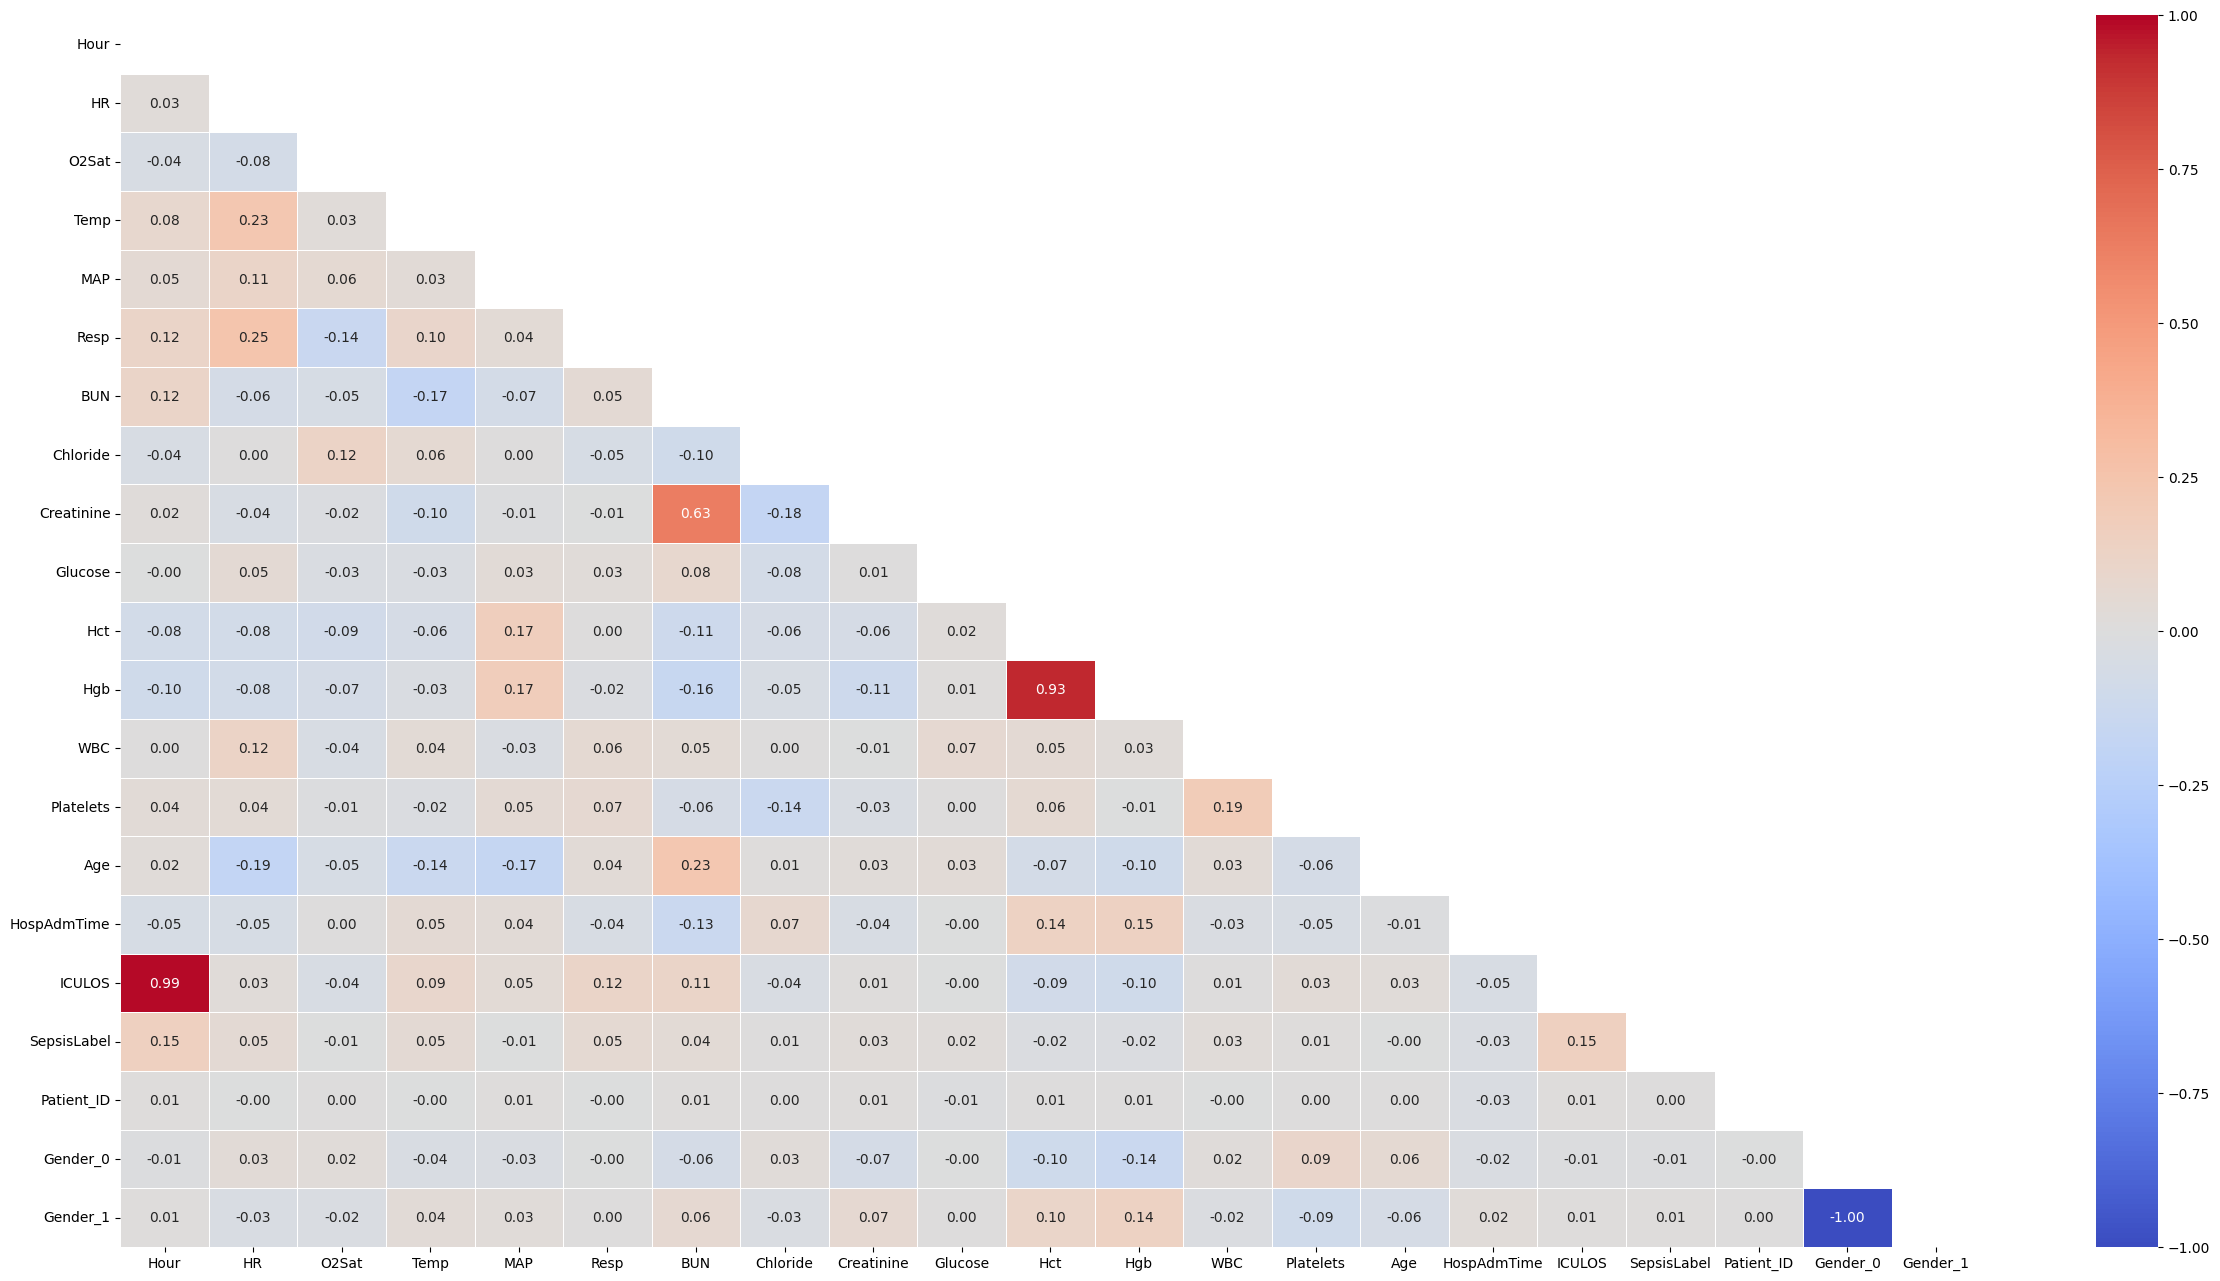

In [35]:
# correlation matrix to check the correlation between the remaining features
correlation_matrix = sepsis_df.corr()
plt.figure(figsize=(30, 16))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, 
            annot=True,       # Add correlation values to the squares
            mask = np.triu(np.ones_like(correlation_matrix, dtype=bool)),
            cmap='coolwarm',  # Color scheme
            vmin=-1, vmax=1,  # Set the scale for the color bar
            fmt='.2f',        # Formatting numbers
            linewidths=.5)    # Space between cells

plt.show()

In [36]:
# columns = sepsis_df.columns

# # Create an empty DataFrame to store the p-values
# p_values = pd.DataFrame(index=columns, columns=columns)

# # Loop through the columns and calculate the p-values
# for col in columns:
#     # Calculate the Pearson correlation coefficient and the p-value
#     corr_test = pearsonr(sepsis_df['SepsisLabel'], sepsis_df[col])
#     # Assign the p-value to the correct position in the DataFrame
#     p_values.loc['SepsisLabel', col] = corr_test[1]

# # Convert all the p-value entries from objects to floats
# p_values = p_values.astype(float)

### 1.3 Sampling Train Set and Test Set

In [37]:
# Split training set and test set
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(sepsis_df, test_size=0.2, train_size=0.8, random_state=1124, shuffle=True, stratify=None)
train_set.head()

,Hour,HR,O2Sat,Temp,MAP,Resp,BUN,Chloride,Creatinine,Glucose,...,Hgb,WBC,Platelets,Age,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,Gender_0,Gender_1
49865,9,115.0,96.0,36.83,82.0,23.0,6.0,102.0,0.5,163.0,...,8.4,6.3,158.0,26.99,-10.68,11,0,213,1,0
152203,2,70.0,100.0,39.44,103.5,20.5,11.0,102.0,1.0,247.0,...,13.0,16.6,300.0,56.25,-0.01,4,0,5601,0,1
256128,31,77.0,97.0,36.67,98.0,19.0,7.0,104.0,0.6,170.0,...,12.2,8.1,176.0,46.30,-0.03,34,0,6764,1,0
68109,50,100.0,98.0,35.83,67.0,19.0,20.0,95.0,1.1,102.0,...,10.1,6.5,207.0,83.41,-134.55,51,0,20611,0,1
753973,28,77.0,96.0,37.17,87.0,10.0,20.0,111.0,0.8,164.0,...,12.9,18.5,179.0,62.25,-0.02,31,0,15007,0,1


In [38]:
# log scale 
columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
for i in columns_normalized:
    train_set[i] = np.log(train_set[i]+1)
    test_set[i] = np.log(test_set[i]+1)


    
# downsample Negative cases
pos_set = train_set[train_set.SepsisLabel == 1]
neg_set = train_set[train_set.SepsisLabel == 0]
# neg_set = neg_set.sample(frac = 0.1)

# neg_set = neg_set.sample(n=100*len(pos_set),replace=True)
# pos_set = pos_set.sample(n=10*len(pos_set),replace=True)

# imputation using mean
imputer = SimpleImputer(strategy='mean')
imputer.fit(pos_set)
pos_set[pos_set.SepsisLabel <= 1 ] = imputer.transform(pos_set)
test_set[test_set.SepsisLabel == 1] = imputer.transform(test_set[test_set.SepsisLabel == 1])
imputer.fit(neg_set)
neg_set[neg_set.SepsisLabel <= 1 ] = imputer.transform(neg_set)
test_set[test_set.SepsisLabel == 0] = imputer.transform(test_set[test_set.SepsisLabel == 0])

train_set = pd.concat([pos_set,neg_set])

# get train/test features & labels
y_train = train_set.SepsisLabel
X_train = train_set.drop(columns=['SepsisLabel', 'Patient_ID'])
y_test = test_set.SepsisLabel
X_test = test_set.drop(columns=['SepsisLabel', 'Patient_ID'])

# balanced sampling
# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler()
# X_train, y_train = ros.fit_resample(X_train, y_train)
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_train, y_train = smote_enn.fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

C:\Users\liyihan\AppData\Local\Temp\ipykernel_12444\231321638.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_set[pos_set.SepsisLabel <= 1 ] = imputer.transform(pos_set)
C:\Users\liyihan\AppData\Local\Temp\ipykernel_12444\231321638.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_set[neg_set.SepsisLabel <= 1 ] = imputer.transform(neg_set)


[(0.0, 590899), (1.0, 618258)]


### 1.4 Correlation Analysis

#### KNN

In [39]:
from sklearn.neighbors import KNeighborsClassifier

k = 2
model = KNeighborsClassifier(n_neighbors=k)
model.fit(X_train, y_train)

# x_test = test_set.drop(columns=["Patient_ID", "SepsisLabel"])
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9895218389931854
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    154639
         1.0       0.70      0.90      0.79      3404

    accuracy                           0.99    158043
   macro avg       0.85      0.94      0.89    158043
weighted avg       0.99      0.99      0.99    158043



#### Logistic Regression

In [40]:
# Initialize the Logistic Regression model
logreg = LogisticRegression()

# Fit the model to the training data
logreg.fit(X_train, y_train)

# Predict on the test set
y_pred = logreg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(report)

Accuracy: 0.7188107034161589
              precision    recall  f1-score   support

         0.0       0.99      0.72      0.83    154639
         1.0       0.05      0.64      0.09      3404

    accuracy                           0.72    158043
   macro avg       0.52      0.68      0.46    158043
weighted avg       0.97      0.72      0.82    158043



Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=10798)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(report)
importances = forest.feature_importances_
print('Importances: ', importances)
indices = np.argsort(importances)[::-1]
print('Importance sort:', indices)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    154639
         1.0       0.88      0.87      0.88      3404

    accuracy                           0.99    158043
   macro avg       0.94      0.93      0.94    158043
weighted avg       0.99      0.99      0.99    158043

Importances:  [0.10908908 0.04248292 0.03843932 0.06028394 0.01882451 0.0495157
 0.06143633 0.04989754 0.06268513 0.04092102 0.04223003 0.04500442
 0.05922326 0.05022471 0.05580243 0.05949288 0.11182184 0.02140725
 0.02121769]
Importance sort: [16  0  8  6  3 15 12 14 13  7  5 11  1 10  9  2 17 18  4]


In [42]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# # define network
# class FCN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.linear1 = nn.Linear(X_train.shape[1], 64)
#         self.linear2 = nn.Linear(64, 64)
#         self.linear3 = nn.Linear(64, 1)
#     def forward(self, X):
#         X = self.linear1(X)
#         X = F.leaky_relu(X)
#         X = self.linear2(X)
#         X = F.leaky_relu(X)
#         X = self.linear3(X)
#         return torch.sigmoid(X)
        


In [43]:
# from torch.utils.data import DataLoader, Dataset
# class SepsisDataset(Dataset):
#     def __init__(self, flag='train', X=None, y=None):
#         assert flag in ['train', 'test', 'valid']
#         self.flag = flag
#         self.X = X
#         self.y = y

#     def __getitem__(self, index):
        
#         return self.X[index, :], self.y[index]
    
#     def __len__(self):
#         return self.X.shape[0]


# train_set = np.concatenate([X_train, np.expand_dims(y_train, axis=1)], axis=1)
# train_set, valid_set = train_test_split(train_set, test_size=0.1, train_size=0.9, random_state=10798, shuffle=True, stratify=None)
# X_train = train_set[:,:-1]
# y_train = train_set[:,-1:]
# X_valid = valid_set[:,:-1]
# y_valid = valid_set[:,-1:]
# y_test = np.expand_dims(y_test, axis=1)

# # create datasets & dataloaders
# train_dataset = SepsisDataset(flag='train', X=X_train, y=y_train)
# train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
# valid_dataset = SepsisDataset(flag='valid', X=X_valid, y=y_valid)
# valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=64, shuffle=True)
# test_dataset = SepsisDataset(flag='test', X=X_test, y=y_test)
# test_dataloader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [44]:
# # hyhper parameters
# model = FCN().to('cuda:0')
# criterion = torch.nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(),lr=0.001)

# train_loss = []
# valid_loss = []
# train_epochs_loss = []
# valid_epochs_loss = []

In [45]:
# from tqdm import tqdm
# num_epochs = 100

# for epoch in tqdm(range(num_epochs)):
#     model.train()
#     train_epoch_loss = []
#     for idx,(data_x,data_y) in enumerate(train_dataloader,0):
#         data_x = data_x.to(torch.float32).to('cuda:0')
#         data_y = data_y.to(torch.float32).to('cuda:0')
#         outputs = model(data_x)
#         optimizer.zero_grad()
#         loss = criterion(data_y,outputs)
#         loss.backward()
#         optimizer.step()
#         train_epoch_loss.append(loss.item())
#         train_loss.append(loss.item())
# #         if idx%(len(train_dataloader)//2)==0:
# #             print("epoch={}/{},{}/{}of train, loss={}".format(
# #                 epoch, num_epochs, idx, len(train_dataloader),loss.item()))
#     train_epochs_loss.append(np.average(train_epoch_loss))
    
#     #=====================valid============================
#     model.eval()
#     valid_epoch_loss = []
#     for idx,(data_x,data_y) in enumerate(valid_dataloader,0):
#         data_x = data_x.to(torch.float32).to('cuda:0')
#         data_y = data_y.to(torch.float32).to('cuda:0')
#         outputs = model(data_x)
#         loss = criterion(data_y,outputs)
#         valid_epoch_loss.append(loss.item())
#         valid_loss.append(loss.item())
#     valid_epochs_loss.append(np.average(valid_epoch_loss))



In [46]:
# # plot loss
# plt.figure(figsize=(12,4))
# plt.subplot(121)
# plt.plot(train_loss[:])
# plt.title("train_loss")
# plt.subplot(122)
# plt.plot(train_epochs_loss[1:],'-o',label="train_loss")
# plt.plot(valid_epochs_loss[1:],'-o',label="valid_loss")
# plt.title("epochs_loss")
# plt.legend()
# plt.show()

In [47]:
# # evaluate the net
# model.eval()
# val = torch.tensor(X_test).reshape(1, -1).float().to("cuda:0")

# results = np.zeros_like(y_test)
# for idx,(data_x,data_y) in enumerate(test_dataloader,0):
# #     target = int(data_y.item())
#     data_x = data_x.to(torch.float32).to('cuda:0')
#     data_y = data_y.to(torch.float32).to('cuda:0')
#     pred_y = model(data_x)
#     pred_y = pred_y > 0.4
#     results[idx * data_y.shape[0]:(idx+1) * data_y.shape[0], :] = pred_y.cpu().numpy()

In [48]:
# # print("Precision            Recall")
# # print(pos_precision,   pos_recall)
# # print(neg_precision,   neg_recall)
# report = classification_report(y_test, results)
# print(report)